In [10]:
import torch
import matplotlib.pyplot as plt

In [11]:
train410, val410 = torch.load("pythia-410M-deduped (Training, Validation) data: bs=8, nbatches=500, length=25).pt")
train1B, val1B   = torch.load("pythia-1B-deduped (Training, Validation) data: bs=8, nbatches=500, length=25).pt")
train1B4, val1B4 = torch.load("pythia-1.4B-deduped (Training, Validation) data: bs=8, nbatches=500, length=25).pt")
train2B8, val2B8 = torch.load("pythia-2.8B-deduped (Training, Validation) data: bs=8, nbatches=500, length=25).pt")
train6B9, val6B9 = torch.load("pythia-6.9B-deduped (Training, Validation) data: bs=8, nbatches=500, length=25).pt")

In [12]:
def compute_threshold(c, training, validation):
    trainlength = len(training[training>=c])
    vallength   = len(validation[validation>= c ])
    return trainlength/(vallength+trainlength)

In [13]:
def plot_fract_in_training_wrt_model_size(threshold):
    model_sizes = [410, 1000, 1400, 2800, 6900] # in millions

    # Example performance metric values for each model size
    # Replace with your own values
    performance = [compute_threshold(threshold, train410, val410), 
                   compute_threshold(threshold, train1B, val1B), 
                   compute_threshold(threshold, train1B4, val1B4), 
                   compute_threshold(threshold, train2B8, val2B8),
                   compute_threshold(threshold, train6B9, val6B9),
                  ]

    plt.plot(model_sizes, performance, marker='o')

    plt.title("Threshold attack success vs Model Size")
    plt.xlabel("Model Size (Millions of Parameters)")
    plt.ylabel("# in training set/(# in training and val sets)")

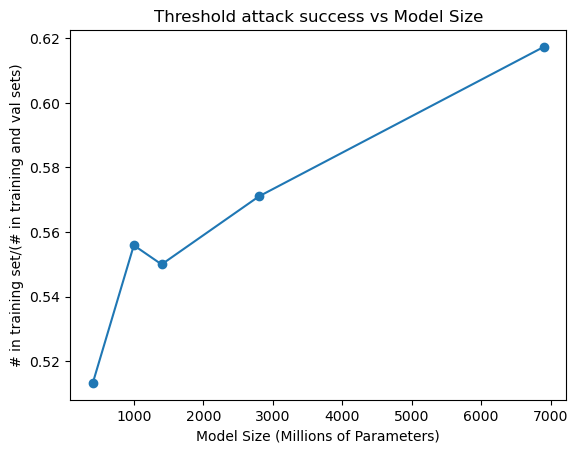

In [14]:
plot_fract_in_training_wrt_model_size(-0.05)
plt.savefig("threshold -0.05 attack.png")